# Physics-based Model for Intrusive Contact Heating

In this lab you will implement a model of crustal rocks being heated by contact to a fresh magma intrusion. These exercises aim to build up your conceptual understanding of how mathematical models are implemented and applied to geological systems. The principles and concepts you will learn underlie most numerical models of Earth and environmental systems and are thus broadly applicable.

The aims of this lab are to:
* understand how a numerical model is constructed 
* implement mathematical equations to describe intrusive contact heating over time
* understand the importance of initial and boundary conditions
* create and explain figures and plots that visualise model behaviour
* experiment with the model to understand its sensitivity to different parameters
* understand the concepts of transient evolution and steady-state dynamic equilibrium
* explore the concepts of numerical stability, model calibration, and verification

Before we get started, we need to tell python which modules we need:

In [1]:
# import some modules that we will need for numerical calculations and for plotting
# we'll shorten their names using "as" so that we don't have to type much later on

# import modules for numerical and symbolic calculations and for plotting
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# tell python to allow plotting to occur within the page
%matplotlib inline

# Customise figure style to use font size 16
from matplotlib import rcParams
rcParams['font.size'] = 16

# import colormaps so we can use shaded values as a function of time
from matplotlib import cm

<img style="float: right; width: 500px; margin: 10px" src="images/contactheating.pdf" alt="Drawing" />

## Theoretical background

Today we will implement a numerical model for intrusive contact heating of crustal rocks and concurrent cooling of the magma intrusion providing the heat. We will be solving a so-called partial differential equation (PDE, has derivatives of both time and space) based on the fundamental principle of energy conservation. The model will represent the lateral flow of heat from a hot intrusion into cooler country rock.

Our starting point is a rock layer conceptualised as a horizontal 1-D profile into a vertically homogeneous crustal profile from the contact of a fresh intrusion out into country rock. To discretise the model we split up the rock layer into discrete volume elements that will act like a row of storage heaters. The model will track the temperature (i.e., heat content) in each of these volume cells and compute the flux of heat that flows horizontally across the faces between them. 

We assume that the only input of heat is the intrusion itself, and the only output is the conductive loss of heat towards the cool country rock at the end of the model layer. We assume there is no vertical flow of heat in or out of the model layer, representing a vertically homogeneous crustal section. The heat added by the intrusion and lost to the country rock are two **boundary conditions** we will impose on either side of our 1-D model domain.

Based on the fundamental principle of energy conservation, we can express the governing equation for the evolving temperature (i.e., heat content) with distance from the intrusion and time as,

\begin{equation}
    {{d T(x,t)}\over{dt}}=-{{dq(x,t)}\over{dx}} \ , \tag{1} \label{eq:1}
\end{equation}

where the change in rock temperature in each volume element $T(x,t)$ [$^\circ$C] through time $t$ [s] is given by the spatial gradient in the heat flux $q(x,t)$ [$^\circ$C/m$^2$/s] with distance $x$ [m]. 

Equation \eqref{eq:1} states that if there is a change in the flux of heat with distance $dq/dx$ this has to be balanced by a change in heat content expressed as temperature $T$. If more heat enters one side of a "storage heater" cell than leaves out the other, the stored heat amount in that cell must increase, and vice versa.

It can be shown both by experiment and from theory that Fourier's law of conductive heat transport $q$ can be expressed as the product of the thermal diffusivity $K_0$ [m$^2$/s] and the spatial gradient in temperature $dT / dx$,

\begin{equation}
    q(x,t) = -K_0 {{dT(x,t)}\over{dx}} \ . \tag{2} \label{eq:2}
\end{equation}

The meaning of this law is that *heat flows from high temperature to low temperature, at the rate allowed by the materials heat diffusivity*. By substituting \eqref{eq:2} into the conservation equation \eqref{eq:1} we get to the final governing equation for our model,

\begin{equation}
    {{d T(x,t)}\over{dt}} = K_0 {{d^2 T(x,t)}\over{dx^2}} \ . \tag{5} \label{eq:5}
\end{equation}

Note that we assumed that the diffusivity $K_0$ is constant and therefore could move it out and in front of the derivatives. Combining the two spatial derivatives from the conservation equation and Fourier's law for the heat flux now means that the rate of temperature evolution depends on the second spatial derivative of temperature, also known in mathematical language as the **Laplacian** of temperature, $d^2 T/dx^2$.

The thermal diffusivity of rock is typically around $10^{-6}$ m$^2$/s. That is quite a small number, indicating that heat flow in the crust will be reasonably slow on human time scales (days to years) and instead take place over geological time (thousand to millions of years).

<img style="float: right; width: 400px; margin: 20px" src="images/stencil.pdf" alt="Drawing" />

## Numerical Implementation

As the next step in the model building process we discretise the continuous governing equation (1) to calculate a numerical solution. We discretise the horizontal coordinate into $n$ grid points, $x^i$, $i=1,2,...,n$, spaced at constant grid spacing, $\Delta x$. Time we discretise into $m$ points in time, $t^k$, $k=1,2,...,m$, spaced at constant step size $\Delta t$. 

Using the finite-difference method, we write the discrete governing equation as,

\begin{equation}
    {{T^{i,k} - T^{i,k-1}}\over{\Delta t}}= - {{q^{i+1/2,k-1} - q^{i-1/2,k-1}}\over{\Delta x}} \ , \tag{9} \label{eq:9}
\end{equation}

where the discrete flux values into the top ($q^{i-1/2}$) and out the bottom ($q^{i+1/2}$) of each volume element are given by the discretised version of equation (2),

\begin{align}
q^{i+1/2} = - K_0 \left(\dfrac{T^{i+1}-T^{i}}{\Delta x} \right) \ , \tag{10} \label{eq:10} \\
q^{i-1/2} = - K_0 \left(\dfrac{T^{i}-T^{i-1}}{\Delta x} \right) \ . \tag{11} \label{eq:11} \\
\end{align}

The figure to the right shows the so-called discretisation stencil, which visualises the spatial relationships and indexing of adjacent discrete cells, and fluxes between them, that are needed to write the discrete governing equation for the cell $i$ (6) and the fluxes in and out of it (7). You can see that the half indices $i-1/2$ and $i+1/2$ refer to quantities located on the top and base faces of the cell $i$, respectively. 

Here we follow the convention that grid cells are **always numbered in the direction of the coordinate axis, and that finite differences are always taken from the higher to the lower index**. Here, our horizontal coordinate axis, $x$, points from the intrusive contact out into the country rock, and therefore the index numbering goes into the same direction as well.

___Hint:___ Always pay close attention to the indexing in your model code, it is one of the most frequent, annoying sources of little errors or *bugs* in numerical modelling.

In the cell below we'll start our simulation code by defining the model domain size and the spatial coordinates spanning the domain.

___Question:___ Can you figure out what exactly the function `np.arange()` does? Look it up online if necessary!

In [2]:
# The model domain goes from the intrusive conntact to a given distance, divided into grid steps of set length
L   = 1.e3   # domain length [m]
dx  = 5.     # grid spacing [m]
x   = np.arange(0.    ,L      ,dx)  # coordinate vector for cell centres
xq  = np.arange(-dx/2.,L+dx/2.,dx)  # coordinate vector for cell faces

Next, we initialise some physical paramters for the heat transport model including the initial temperature of the hot intrusion and the cool crustal layer, and the thermal diffusivity. We also initialise two arrays (lists of numbers) to store the discrete temperature and heat flux values in once we're calculating them below.

In [3]:
# set model parameters for the thermal model
Tin = 1200. # intrusion temperature typical of basalt [C] (left boundary condition)
Tcr = 400.  # typical crustal temperature around 10 km depth [C] (right boundary condition)
K0  = 1e-6  # heat diffusivity [m2/s]

# set up arrays to store temperature and heat flux values
T   = Tcr*np.ones(int(L/dx)) # create array to store temperatures at each grid point, initialise at Tcr
print('The shape of Temp is',np.shape(T)) # display the shape of the array Temp

q   = np.zeros(np.shape(xq))
print('The shape of q is   ',np.shape(q)) # display the shape of the array q

The shape of Temp is (200,)
The shape of q is    (201,)


___Question:___ Compare the length of the two arrays we created to store temperature and heat flux values along the crustal layer with the conceptual sketch of the model above. Why is there one more value in `T` than in `q`?

Now let's create a function that initialises an empty figure with desired format that we will use to plot the model output on as the run proceeds.

In [6]:
def init_fig(x,xq,T,q):

    # set up the figure 
    fig = plt.figure(2,figsize=(12,8));

    # add axes to subplot
    ax1 = fig.add_subplot(211)

    # set the x axis limits, move labels to the top of the box and label
    ax1.set_xlim((0,L))

    # set the y axis limits and invert the y axis
    ax1.set_ylabel("Temperature [$^\circ$C]")

    # create an empty line object that we will populate repeatedly to create the animation
    ax1.plot(x,T,'k-');

    # add axes to subplot
    ax2  = fig.add_subplot(212)

    # set the x axis limits, move labels to the top of the box and label
    ax2.set_xlim((0,L))
    ax2.set_xlabel("Distance [m]")

    # set the y axis limits and invert the y axis
    ax2.set_ylabel("Heat flux [$^\circ$C/yr]")

    # create an empty line object that we will populate repeatedly to create the animation
    ax2.plot(xq,q,'k-');

    return fig, ax1, ax2

<div class="alert alert-block alert-info">
<font color="black">
<h3>Task 1</h3>
<p>Since both relations vary as a function of water content, make a plot to explore how hydraulic conductivity varies with pressure head in a code block below.
<p></p>
</font>
</div>

---  t = 9.9025e-02 kyr;  max q = 2.5454e+02 C/yr;  min|mean|max T = 4.0000e+02 | 4.5251e+02 | 1.2000e+03 C;
---  t = 1.9805e-01 kyr;  max q = 1.8008e+02 C/yr;  min|mean|max T = 4.0000e+02 | 4.7340e+02 | 1.2000e+03 C;
---  t = 2.9708e-01 kyr;  max q = 1.4706e+02 C/yr;  min|mean|max T = 4.0000e+02 | 4.8943e+02 | 1.2000e+03 C;
---  t = 3.9610e-01 kyr;  max q = 1.2737e+02 C/yr;  min|mean|max T = 4.0000e+02 | 5.0295e+02 | 1.2000e+03 C;
---  t = 4.9513e-01 kyr;  max q = 1.1393e+02 C/yr;  min|mean|max T = 4.0000e+02 | 5.1486e+02 | 1.2000e+03 C;
---  t = 5.9415e-01 kyr;  max q = 1.0400e+02 C/yr;  min|mean|max T = 4.0000e+02 | 5.2563e+02 | 1.2000e+03 C;
---  t = 6.9318e-01 kyr;  max q = 9.6290e+01 C/yr;  min|mean|max T = 4.0000e+02 | 5.3553e+02 | 1.2000e+03 C;
---  t = 7.9220e-01 kyr;  max q = 9.0073e+01 C/yr;  min|mean|max T = 4.0000e+02 | 5.4475e+02 | 1.2000e+03 C;
---  t = 8.9123e-01 kyr;  max q = 8.4923e+01 C/yr;  min|mean|max T = 4.0000e+02 | 5.5340e+02 | 1.2000e+03 C;
---  t = 9.9025e-01

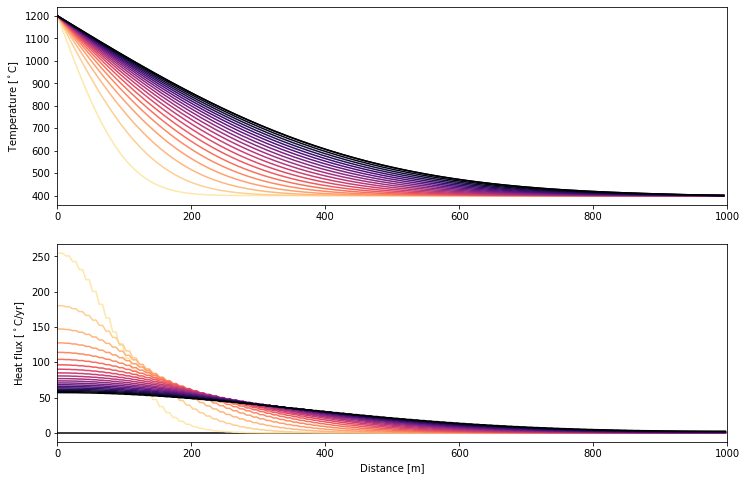

In [9]:
# initialise figure to plot model results
fig_out, ax1, ax2 = init_fig(x,xq,T,q)

# set initial temperature and flux values
T  = Tcr*np.ones(int(L/dx)) # create array to store temperatures on each cell mid-point, initialise at Tcr
q  = np.zeros(np.size(xq))  # create array to store heat flux on each cell face, initialise at 0

# set intrusive contact boundary condition
T[0] = Tin;

# set model timing parameters
yr   = 3600*24*365.25  # number of seconds in a year
dt   = 1.25e7          # set time step size
tend = 5e3*dt          # set stopping time
nop  = 250             # set number of times result is plotted during model run
t    = 0               # set initial time to zero
m    = 0               # set time step counter to zero

# enter time stepping loop
while t < tend:

    # update time
    t += dt
    m += 1
    
    # get water flux on cell boundaries
    q[1:-1] = - K0 * np.diff(T)/dx
    
    # set constant in/out-flux boundary conditions on top and base of domain
    q[ 0] = q[ 1];  # left boundary free inflow (dq/dx = 0)
    q[-1] = q[-2];  # right boundary free outflow (dq/dx = 0)
    
    # update temperature with the heat flux gradient
    T -= np.diff(q)/dx * dt
    
    # plot the results
    if not (m % nop):
        print('---  t = %4.4e kyr;  max q = %4.4e C/yr;  min|mean|max T = %4.4e | %4.4e | %4.4e C;' % (t/1000/yr,np.max(q[1:-1]*yr),np.min(T),np.mean(T),np.max(T)))
        ax1.plot(x ,T   ,color=cm.magma((tend-t)/tend),label=str(t));
        ax2.plot(xq,q*yr,color=cm.magma((tend-t)/tend),label=str(t));

## Numerical Stability

You should now be able to see the model results above show how the heat from the intrusion is spreading out into the cooler crust. So far so good, the model seems to run! However, you may notice that some of the lines appear a bit 'wiggly'. That may be a sign of trouble!

<div class="alert alert-block alert-info">
<font color="black">
<h3>Task 2</h3>
<p>Return to the previous code cell, slightly increase and decrease the time step (e.g., 1.0e7–1.5e7) and let the model run again! What do you observe? How can you stabilise the model and get a smooth solution?
<p></p>
</font>
</div>

You should have found out by now that the model is actually very unstable! If the time step is even just a little larger, the model goes into an unstable mode where the calculated heat flux and temperature begin to oscillate wildly! The model appears to remain stable, however, if you reduce the time step to below $10^{7}$ s.

This phenomenon is called **numerical instability**. If the time step is set too large, the numerical solution becomes unstable and is no longer a good approximation of the original equation or may indeed become utterly unusable.

To be very brief, what triggers the type of instability we see here is when the time-stepping algorithm takes steps that cause the temperature front to spread away from the intrusive contact at a rate of more than half a grid cell per time step. If that happens, the algorithm "overshoots" the correct solution, which then causes the next time step to "undershoot" in turn, and so on.

We can fix the issue by thinking about what process sets the rate at which the temperature front is migrating across the domain. Or, to put it differently, what is the characteristic time for heat diffusion to advance a temperature front across a given distance?

To find the answer to this question we can apply the concept of scaling analysis. In scaling analysis we identify *characteristic scales* for all variables and parameters in our governing equation and group some (or all) of them together in ways that return some desired dimensional units. 

In our problem we have the independent variables of time, $t$ [s], and space, $x$ [m], the dependent variable of temperature, $T$ [$\circ$C], and the model parameter of thermal diffusivity, $K$ [m$^2$/s]. We will define characteristic scales for each and name them $t_0$, $x_0$, $T_0$, and $K_0$. All of these have the same units as the variable or parameter they represent and a value that is a reasonably representative number.

Not all of these scales can be independently chosen, however. Many of are combinations of basic units, for example the diffusivity scale [m$^2$/s] combines the dimensions of length [m] and time [s]. Hence, we could either identify independent scales for distance and time and use them to define a dependent scale for diffusivity, or vice-versa.

Let's play through both examples: First, let's take the length of our domain as the characteristic scale for distance, $x_0 = L = 1000 m$, and 1 kyr as characteristic scale for time, $t_0 = 1000 yr$. Combining these two in the appropriate way to get dimensions of [m$^2$/s] we can now express the characteristic scale for diffusivity as

\begin{equation}
    K_0 = {x_0^2 \over t_0} = 10^3 \ \mathrm{m^2/yr} \ = 3.2 \times 10^{-5} \ \mathrm{m^2/s} \ . \tag{12} \label{eq:12}
\end{equation}

The result is the characteristic diffusivity that would allow heat to diffuse through 1 km of crust in a thousand years. That's interesting but not quite what we were after.

Let's return now to our original question: how much time does it take to diffuse heat through half a grid cell in our numerical model? We can find this by rearranging equation (12) so that we have $t_0$ as the unknown on the left hand side, and using $K_0 = K = 10^{-6}$ m$^2$/s and $x_0 = \Delta x/2 = 2.5$ m as the known scales on the right,

\begin{equation}
    t_0|_{\Delta x / 2} = {x_0^2 \over K_0} = {(\Delta x / 2)^2 \over K} \ . \tag{13} \label{eq:13}
\end{equation}

The result of equation (13) will be the characteristic time for heat diffusion to pass through half a grid cell and  provides the upper limit for a stable numerical time step in our model.

\begin{equation}
    \Delta t_\mathrm{stable} \leq t_0|_{\Delta x / 2} \ . \tag{14} \label{eq:14}
\end{equation}

<div class="alert alert-block alert-info">
<font color="black">
<h3>Task 3</h3>
<p>Test if the time step stability criterion we just derived indeed results in a stable numerical solution! Copy the model routine from the code cell above into the empty cell below. Find the line towards the top of the model algorithm where the time step is set. Replace the number previously set for the time step with the stable step size calculated from the diffusivity and grid step as shown in eq. (13) above. Run the model again with this time step. Are you getting a stable result now?
<p></p>
</font>
</div>

---  t = 4.9513e-02 kyr;  max q = 3.6016e+02 C/yr;  min|mean|max T = 4.0000e+02 | 4.3774e+02 | 1.2000e+03 C;
---  t = 9.9025e-02 kyr;  max q = 2.5473e+02 C/yr;  min|mean|max T = 4.0000e+02 | 4.5250e+02 | 1.2000e+03 C;
---  t = 1.4854e-01 kyr;  max q = 2.0801e+02 C/yr;  min|mean|max T = 4.0000e+02 | 4.6383e+02 | 1.2000e+03 C;
---  t = 1.9805e-01 kyr;  max q = 1.8015e+02 C/yr;  min|mean|max T = 4.0000e+02 | 4.7339e+02 | 1.2000e+03 C;
---  t = 2.4756e-01 kyr;  max q = 1.6113e+02 C/yr;  min|mean|max T = 4.0000e+02 | 4.8181e+02 | 1.2000e+03 C;
---  t = 2.9708e-01 kyr;  max q = 1.4709e+02 C/yr;  min|mean|max T = 4.0000e+02 | 4.8943e+02 | 1.2000e+03 C;
---  t = 3.4659e-01 kyr;  max q = 1.3618e+02 C/yr;  min|mean|max T = 4.0000e+02 | 4.9643e+02 | 1.2000e+03 C;
---  t = 3.9610e-01 kyr;  max q = 1.2739e+02 C/yr;  min|mean|max T = 4.0000e+02 | 5.0294e+02 | 1.2000e+03 C;
---  t = 4.4561e-01 kyr;  max q = 1.2011e+02 C/yr;  min|mean|max T = 4.0000e+02 | 5.0907e+02 | 1.2000e+03 C;
---  t = 4.9513e-01

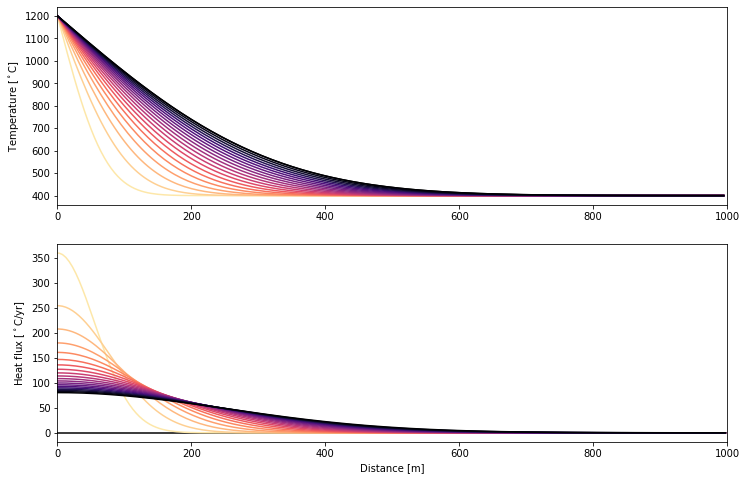

In [11]:
# initialise figure to plot model results
fig_out, ax1, ax2 = init_fig(x,xq,T,q)

# set initial temperature and flux values
T  = Tcr*np.ones(int(L/dx)) # create array to store temperatures on each cell mid-point, initialise at Tcr
q  = np.zeros(np.size(xq))  # create array to store heat flux on each cell face, initialise at 0

# set intrusive contact boundary condition
T[0] = Tin;

# set model timing parameters
yr   = 3600*24*365.25  # number of seconds in a year
dt   = (dx/2)**2/K0    # set time step size
tend = 5e3*dt          # set stopping time
nop  = 250             # set number of times result is plotted during model run
t    = 0               # set initial time to zero
m    = 0               # set time step counter to zero

# enter time stepping loop
while t < tend:

    # update time
    t += dt
    m += 1
    
    # get water flux on cell boundaries
    q[1:-1] = - K0 * np.diff(T)/dx
    
    # set constant in/out-flux boundary conditions on top and base of domain
    q[ 0] = q[ 1];  # left boundary free inflow (dq/dx = 0)
    q[-1] = q[-2];  # right boundary free outflow (dq/dx = 0)
    
    # update temperature with the heat flux gradient
    T -= np.diff(q)/dx * dt
    
    # plot the results
    if not (m % nop):
        print('---  t = %4.4e kyr;  max q = %4.4e C/yr;  min|mean|max T = %4.4e | %4.4e | %4.4e C;' % (t/1000/yr,np.max(q[1:-1]*yr),np.min(T),np.mean(T),np.max(T)))
        ax1.plot(x ,T   ,color=cm.magma((tend-t)/tend),label=str(t));
        ax2.plot(xq,q*yr,color=cm.magma((tend-t)/tend),label=str(t));

# Dyke intrusion
You should now have a fully functioning and numerically stable model for intrusive contact heating. So far, we've only looked at how heat from an adjacent intrusion spreads into the cooler wall rock. We set the intrusion temperature to be constant (left boundary), meaning that heat will continue flowing out into the crust as long as we keep the model running. In reality, this could only be the case if the intrusion is very large and therefore has sufficient heat to maintain a constant temperature despite continually loosing heat into the surrounding crust.

That will not normally be the case in nature. Rather, intrusions come in all sizes and shapes. Often, they take the shape of magma-filled fractures or dykes of no more than a few metres thickness. Clearly the amount of heat they can diffuse into the crust is very limited, meaning that they won't go on heating the crust indefinitely but will cool down themselves in the process.

That, by the way, is exactly the meaning of the principle of ___energy conservation___: There is a limited amount of energy in natural systems. All natural processes can do is to redistribute that finite amount of energy. Any natural process *must exactly conserve the total amount of energy originally in the system* (initial condition) and *exactly account for all energy passing between the system and its environment* (boundary conditions).

Let's build a thermal model of dyke intrusion by slightly modifying the initial and boundary conditions of our original model above.

<div class="alert alert-block alert-info">
<font color="black">
<h3>Task 4</h3>
<p>Build a thermal model of dyke intrusion by copying your stable, working code from the code cell above to the cell prepared below. Replace the initial condition of the previous code version with the few lines of code given at the top of the following cell. Try out different widths of the dyke you wish to inject by setting the new parameter $W$. There's a command prepared at the end of the box that saves the figures produced to the directory this notebook is located in. Make sure to change the file name every time you run with a different dyke width to avoid overwriting previous results. Compare how the model changes with different dyke width!
<p></p>
</font>
</div>

---  t = 4.9513e-02 kyr;  max q = 1.4818e+02 C/yr;  min|mean|max T = 4.0000e+02 | 4.7600e+02 | 8.8359e+02 C;
---  t = 9.9025e-02 kyr;  max q = 8.2660e+01 C/yr;  min|mean|max T = 4.0000e+02 | 4.7600e+02 | 7.6162e+02 C;
---  t = 1.4854e-01 kyr;  max q = 5.7246e+01 C/yr;  min|mean|max T = 4.0000e+02 | 4.7600e+02 | 7.0101e+02 C;
---  t = 1.9805e-01 kyr;  max q = 4.3763e+01 C/yr;  min|mean|max T = 4.0000e+02 | 4.7600e+02 | 6.6324e+02 C;
---  t = 2.4756e-01 kyr;  max q = 3.5433e+01 C/yr;  min|mean|max T = 4.0000e+02 | 4.7598e+02 | 6.3684e+02 C;
---  t = 2.9708e-01 kyr;  max q = 2.9751e+01 C/yr;  min|mean|max T = 4.0000e+02 | 4.7594e+02 | 6.1706e+02 C;
---  t = 3.4659e-01 kyr;  max q = 2.5645e+01 C/yr;  min|mean|max T = 4.0000e+02 | 4.7586e+02 | 6.0152e+02 C;
---  t = 3.9610e-01 kyr;  max q = 2.2535e+01 C/yr;  min|mean|max T = 4.0000e+02 | 4.7571e+02 | 5.8891e+02 C;
---  t = 4.4561e-01 kyr;  max q = 2.0096e+01 C/yr;  min|mean|max T = 4.0000e+02 | 4.7548e+02 | 5.7840e+02 C;
---  t = 4.9513e-01

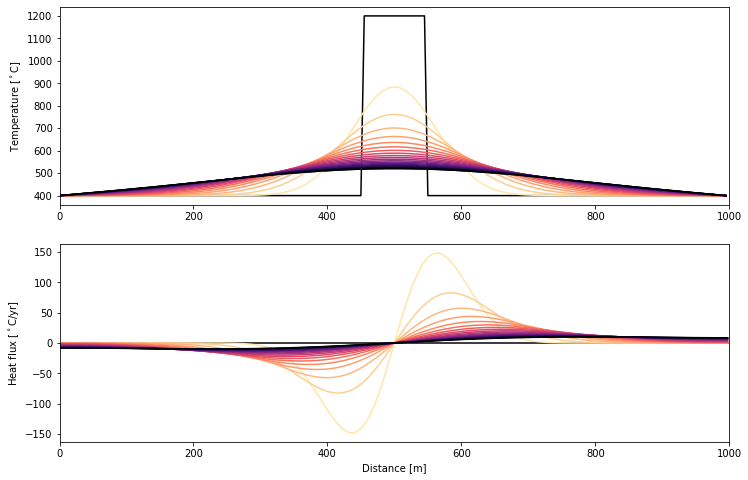

In [13]:
# initialise figure to plot model results
fig_out, ax1, ax2 = init_fig(x,xq,T,q)

# set initial temperature and flux values
T  = Tcr*np.ones(int(L/dx)) # create array to store temperatures on each cell mid-point, initialise at Tcr
q  = np.zeros(np.size(xq))  # create array to store heat flux on each cell face, initialise at 0
     
# inject dyke intrusion
W  = 100  # width of dyke
T[abs(x-L/2) < W/2] = Tin;  # insert dyke to initial condition
ax1.plot(x ,T   ,'k-',label=str(t));  # plot initial condition

# set model timing parameters
yr   = 3600*24*365.25  # number of seconds in a year
dt   = (dx/2)**2/K0    # set time step size
tend = 5e3*dt          # set stopping time
nop  = 250             # set number of times result is plotted during model run
t    = 0               # set initial time to zero
m    = 0               # set time step counter to zero

# enter time stepping loop
while t < tend:

    # update time
    t += dt
    m += 1
    
    # get water flux on cell boundaries
    q[1:-1] = - K0 * np.diff(T)/dx
    
    # set constant in/out-flux boundary conditions on top and base of domain
    q[ 0] = q[ 1];  # left boundary free inflow (dq/dx = 0)
    q[-1] = q[-2];  # right boundary free outflow (dq/dx = 0)
    
    # update temperature with the heat flux gradient
    T -= np.diff(q)/dx * dt
    
    # plot the results
    if not (m % nop):
        print('---  t = %4.4e kyr;  max q = %4.4e C/yr;  min|mean|max T = %4.4e | %4.4e | %4.4e C;' % (t/1000/yr,np.max(q[1:-1]*yr),np.min(T),np.mean(T),np.max(T)))
        ax1.plot(x ,T   ,color=cm.magma((tend-t)/tend),label=str(t));
        ax2.plot(xq,q*yr,color=cm.magma((tend-t)/tend),label=str(t));
        
# save the results as an image file
# rename this for every parameter variation
fig_out.savefig("DykeIntrusion_W100.png",dpi=300)

<div class="alert alert-block alert-info">
<font color="black">
<h3>Bonus Task</h3>
<p>Here's a challenge for you if you feel up for it. In the model above we assumed that the heat diffusivity is constant over all the domain. That is not necessarily true in natural systems. For example, the magma may have different diffusivity than the wall rock, or the wall rock may comprise different rock types with different properties. In this task, you will modify the model you built to allow for spatially variable diffusivity and test this model for such scenarios.
<p></p>
</font>
</div>

<img style="float: right; width: 400px; margin: 20px" src="images/stencilK.pdf" alt="Drawing" />


The governing equation for heat transport with spatially variable diffusivity is, in the first instance, the same as eq. (1) above,

\begin{equation}
    {{d T(x,t)}\over{dt}}=-{{dq(x,t)}\over{dx}} \ , \tag{15} \label{eq:15}
\end{equation}

but with the heat flux $q(x,t)$ now featuring $K(x)$, the spatially variable diffusivity,

\begin{equation}
    q_x = - K(x) {{dT}\over{dx}} \ , \tag{16} \label{eq:16}
\end{equation}

When we discretise this slightly modified flux equation we need to define the diffusivities, $K^i$, located at the discreet cell centres, $x^i$. To calculate the discrete fluxes we need to evaluate the diffusivities at the flux-locations on the faces between cells. We achieve that by taking the average between the values in the two adjacent cells, e.g., $K^{i-1/2} = (K^i+K^{i-1})/2$. You'll see these marked in the modified numerical stencil figure to the right. The discrete representation of the fluxes then takes the form,

\begin{align}
q^{i+1/2} = - \dfrac{K^{i+1}+K^{i}}{2} \left(\dfrac{T^{i+1}-T^{i}}{\Delta x} \right) \ , \tag{17} \label{eq:17} \\
q^{i-1/2} = - \dfrac{K^{i}+K^{i-1}}{2} \left(\dfrac{T^{i}-T^{i-1}}{\Delta x} \right) \ . \tag{18} \label{eq:18} \\
\end{align}

___Now copy the working code from above into the cell below and make the following modifications:___
* Change the definition of the diffusivity `K` to be an array of the same size as `T` and initialise all cells on the same value of `K0` as above. Hint: check how we initialised the temperature array `T` above, you should be able to use the same type of command.
* Calculate the stable time step size not with `K0` but instead as function of the maximum value in the array `K` you just initialised. Use the `numpy` function `np.max()` to do that.
* Change the calculation of the heat flux `q` according to eqs. (17) & (18) above. Hint: to calculate the diffusivities at the flux-locations on the cell faces, use `(K[1:]+K[:-1])/2`. Can you figure out why this is the right way to do it?

---  t = 4.9513e-02 kyr;  max q = 1.4818e+02 C/yr;  min|mean|max T = 4.0000e+02 | 4.7600e+02 | 8.8359e+02 C;
---  t = 9.9025e-02 kyr;  max q = 8.2660e+01 C/yr;  min|mean|max T = 4.0000e+02 | 4.7600e+02 | 7.6162e+02 C;
---  t = 1.4854e-01 kyr;  max q = 5.7246e+01 C/yr;  min|mean|max T = 4.0000e+02 | 4.7600e+02 | 7.0101e+02 C;
---  t = 1.9805e-01 kyr;  max q = 4.3763e+01 C/yr;  min|mean|max T = 4.0000e+02 | 4.7600e+02 | 6.6324e+02 C;
---  t = 2.4756e-01 kyr;  max q = 3.5433e+01 C/yr;  min|mean|max T = 4.0000e+02 | 4.7598e+02 | 6.3684e+02 C;
---  t = 2.9708e-01 kyr;  max q = 2.9751e+01 C/yr;  min|mean|max T = 4.0000e+02 | 4.7594e+02 | 6.1706e+02 C;
---  t = 3.4659e-01 kyr;  max q = 2.5645e+01 C/yr;  min|mean|max T = 4.0000e+02 | 4.7586e+02 | 6.0152e+02 C;
---  t = 3.9610e-01 kyr;  max q = 2.2535e+01 C/yr;  min|mean|max T = 4.0000e+02 | 4.7571e+02 | 5.8891e+02 C;
---  t = 4.4561e-01 kyr;  max q = 2.0096e+01 C/yr;  min|mean|max T = 4.0000e+02 | 4.7548e+02 | 5.7840e+02 C;
---  t = 4.9513e-01

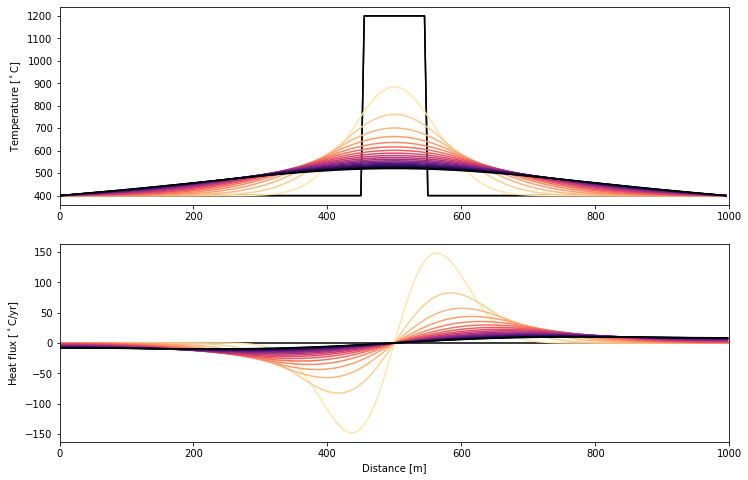

In [16]:
# initialise figure to plot model results
fig_out, ax1, ax2 = init_fig(x,xq,T,q)

# set initial temperature and flux values
K  = K0*np.ones(int(L/dx))  # create array to store temperatures on each cell mid-point, initialise at Tcr
T  = Tcr*np.ones(int(L/dx)) # create array to store temperatures on each cell mid-point, initialise at Tcr
q  = np.zeros(np.size(xq))  # create array to store heat flux on each cell face, initialise at 0
     
# inject dyke intrusion
W  = 100  # width of dyke
T[abs(x-L/2) < W/2] = Tin;  # insert dyke to initial condition
ax1.plot(x ,T   ,'k-',label=str(t));  # plot initial condition

# set model timing parameters
yr   = 3600*24*365.25        # number of seconds in a year
dt   = (dx/2)**2/np.max(K)   # set time step size
tend = 5e3*dt                # set stopping time
nop  = 250                   # set number of times result is plotted during model run
t    = 0                     # set initial time to zero
m    = 0                     # set time step counter to zero

# enter time stepping loop
while t < tend:

    # update time
    t += dt
    m += 1
    
    # get water flux on cell boundaries
    q[1:-1] = - (K[1:]+K[:-1])/2 * np.diff(T)/dx
    
    # set constant in/out-flux boundary conditions on top and base of domain
    q[ 0] = q[ 1];  # left boundary free inflow (dq/dx = 0)
    q[-1] = q[-2];  # right boundary free outflow (dq/dx = 0)
    
    # update temperature with the heat flux gradient
    T -= np.diff(q)/dx * dt
    
    # plot the results
    if not (m % nop):
        print('---  t = %4.4e kyr;  max q = %4.4e C/yr;  min|mean|max T = %4.4e | %4.4e | %4.4e C;' % (t/1000/yr,np.max(q[1:-1]*yr),np.min(T),np.mean(T),np.max(T)))
        ax1.plot(x ,T   ,color=cm.magma((tend-t)/tend),label=str(t));
        ax2.plot(xq,q*yr,color=cm.magma((tend-t)/tend),label=str(t));
        
# save the results as an image file
# rename this for every parameter variation
fig_out.savefig("DykeIntrusion_W100.png",dpi=300)

You should now have a functioning model with variable diffusivity. Bear in mind, though, we haven't yet initialised `K` with spatially variable values yet, so the result should be exactly the same as when we used the constant diffusivity `K0` above.

To test the new model's capabilities, you can try the following three cases. For each case, create a new code cell below, copy down the variable diffusivity code and modify the definition of `K` at the top of the code. Make sure to change the filename at the end of the code every time you try a new case to not overwrite the figures of previous model runs.

___Case 1:___ The intruded magma may have a different diffusivity from the wall rock. Initialise a model where you use the same commands we used above to initialise a higher temperature within the intrusion to also initialise a contrasting diffusivity within the intrusion. This can be either higher or lower, and I recommend you test values for the magma's diffusivity of up to an order of magnitude higher or lower, while leaving the wall rock's diffusivity as it was on `K0`.

___Case 2:___ The wall rock around the intrusion may not be homogeneous. For example, you could examine the case where the intrusion followed a contact between two lithologies. For this case, initialise `K` with contrasting values for the rock to the left of the intrusion and to the right of the intrusion, as well as maintaining a different value for the magma as in Case 1 above.